In [49]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import numpy as np
from math import cos
from sklearn.gaussian_process.kernels import RBF
from mpl_toolkits.mplot3d import Axes3D
import itertools
import sys
from python_scripts.bayesian_optimization import IBO
%pylab inline
%load_ext autoreload 

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cos']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
%autoreload 2

# Define the function

In [51]:
oneD_function =lambda x: cos(1000*x-500)+(abs(x*100_000))/(x**4+1000)

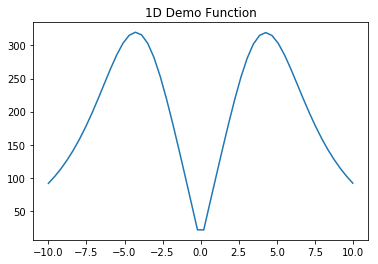

In [3]:
plt.plot(np.linspace(-10,10),[oneD_function(_) for _ in np.linspace(-10,10)])
plt.title('1D Demo Function');

# Setup the package BayesianOptimization

In [4]:
bo = BayesianOptimization(oneD_function,
                          {'x': (0, 50)})

In [5]:
bo.explore({'x': np.linspace(0,50)})

# Setup my implementation

In [6]:
test_x = np.array(np.linspace(0,50,1000)).reshape(-1,1)
train_x = np.array(np.linspace(0,50,1)).reshape(-1,1)
train_y_numbers = np.array([oneD_function(_) for _ in train_x]).reshape(-1,1)
y_var = 10

# My implementation to run Bayesian Optimization

## First, sample points and update the posterior

In [7]:
def test_gaussian_process(test_x, train_x, train_y_numbers, y_var, kernel, return_cov = False,
                          return_sample = False, covariance_noise = 5e-5, n_posteriors = 5):
    """Test one new point in the Gaussian process and update the posterior or an array of points
    Returns the mean, var from normal distribution from the sampled point.
    Return cov = True will return the full covariance matrix.
    
    If return_sample= True 
    returns samples ( a vector) from the informed posterior and the uninformed prior distribution
    
    Covariance diagonal noise is used to help enforce positive definite matrices
    
    N_posteriors indicates the number of posterior functions to create when sampling"""
    
    from numpy import linalg as la
    #https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite/43244194#43244194
    def nearestPD(A):
        """Find the nearest positive-definite matrix to input

        A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
        credits [2].

        [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

        [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
        matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
        """

        B = (A + A.T) / 2
        _, s, V = la.svd(B)

        H = np.dot(V.T, np.dot(np.diag(s), V))

        A2 = (B + H) / 2

        A3 = (A2 + A2.T) / 2

        if isPD(A3):
            return A3

        spacing = np.spacing(la.norm(A))
        # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
        # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
        # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
        # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
        # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
        # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
        # `spacing` will, for Gaussian random matrixes of small dimension, be on
        # othe order of 1e-16. In practice, both ways converge, as the unit test
        # below suggests.
        I = np.eye(A.shape[0])
        k = 1
        while not isPD(A3):
            mineig = np.min(np.real(la.eigvals(A3)))
            A3 += I * (-mineig * k**2 + spacing)
            k += 1

        return A3

    def isPD(B):
        """Returns true when input is positive-definite, via Cholesky"""
        try:
            _ = la.cholesky(B)
            return True
        except la.LinAlgError:
            return False
    
    
    
    # define the covariance matrices
    covariance_train_train = kernel(train_x,train_x,train=True)
    covariance_test_train  = kernel(test_x,train_x)
    covariance_test_test  = kernel(test_x,test_x)
    

    # Use cholskey decomposition to increase speed for calculating mean
    try :# First try, 
        L_test_test = np.linalg.cholesky(covariance_test_test + covariance_noise*np.eye(len(covariance_test_test)))
        L_train_train = np.linalg.cholesky(covariance_train_train + covariance_noise*np.eye(len(covariance_train_train)))
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        

    # Full matrix calculation of mean and covariance, much slower than cholesky decomposition
    except Exception as e:
        print(e)#LinAlgError: # In case the covariance matrix is not positive definite 
        # Find the near positive definite matrix to decompose
        decompose_train_train = nearestPD(covariance_train_train + covariance_noise*np.eye(len(train_x)))
        decompose_test_test = nearestPD(covariance_test_test + covariance_noise*np.eye(len(test_x)))
        
        # cholskey decomposition within the try except block
        L_train_train = np.linalg.cholesky(decompose_train_train  )
        L_test_test = np.linalg.cholesky(decompose_test_test  )
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        
        
#         ##### FULL INVERSION ####
#         mus = covariance_test_train  @ np.linalg.pinv(covariance_train_train) @ train_y_numbers
#         s2 = covariance_test_test - covariance_test_train @ np.linalg.pinv(covariance_train_train ) \
#                      @ covariance_test_train.T
        

    def sample_from_posterior(n_priors=3, n_post=5):
        """Draw samples from the prior distribution of the GP.
        len(test_x) is the number of samplese to draw.
        Resource: http://katbailey.github.io/post/gaussian-processes-for-dummies/.
        
        N-Posteriors / N-Priors tells the number of functions to samples from the dsitribution"""

        # Draw samples from the posterior at our test points.
        covariance_test_test  = kernel(test_x,test_x)
        try: # try inside sample from posterior function
            L = np.linalg.cholesky(covariance_test_test +  covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk))
        except Exception as e:
            # Find the neareset Positive Definite Matrix
            near_decompose = nearestPD(covariance_test_test +  covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk))
            L = np.linalg.cholesky(near_decompose.astype(float) ) # within posterior
        # sample from the posterior
        f_post = mus.reshape(-1,1) + np.dot(L, np.random.normal(size=(len(test_x),n_posteriors)))

        # Sample X sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior_uninformed = np.dot(L_test_test, np.random.normal(size=(len(test_x),n_priors)))
        # For the posterior, the columns are the vector for that function
        return (f_prior_uninformed, f_post)


    if return_cov == True:
        return y_pred_mean.ravel(), var_y_pred_diag.ravel(), var_y_pred
        
    if return_sample == True:
        f_prior, f_post = sample_from_posterior(n_post = n_posteriors)
        return mus.ravel(), s2.ravel(), f_prior, f_post
    else:
        return mus.ravel(), s2.ravel()
    

## Second, define the squarred kernel

In [8]:
def squarred_kernel(a, b, param=2.0, train=False, train_noise = 5e-3, vertical_scale=50):
    """Calculated the squarred exponential kernel. 
    Adds a noise term for the covariance of the training data
    Adjusting the param changes the difference where points will have a positive covariance
    Returns a covaraince Matrix.
    Vertical scale controls the vertical scale of the function"""
    if train == False:
        a = np.array(a)
        b = np.array(b)
        
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return vertical_scale*np.exp(-.5 * (1/param) * sqdist)

    else:
        noisy_observations = train_noise*np.eye(len(a))
        a = np.array(a)
        b = np.array(b)
        
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T) 
        return vertical_scale*np.exp(-.5 * (1/param) * sqdist) + noisy_observations 

## Next, define the acquisition function

In [9]:
def expected_improvement(mean_x, sigma_squarred_x, y_val_for_best_hyperparameters, normal_dist=None, point_est = False):
    """Finds the expected improvement of a point give the current best point.
    If point_est = False, then computes the expected value on a vector from the posterior distribution.
    """
    from scipy.stats import norm
    
    with np.errstate(divide='ignore'): # in case sigma equals zero
        # Expected val for one point
        if point_est ==True:
            sigma_x = np.sqrt(sigma_squarred_x) # get the standard deviation from the variance

            Z = (mean_x - y_val_for_best_hyperparameters) / sigma_x

            if round(sigma_x,8) == 0:
                return 0
            else:
                return (mean_x - y_val_for_best_hyperparameters)*normal_dist.cdf(Z) + sigma_x*normal_dist.pdf(Z)

        else:
            # Sample from the posterior functions
            for _ in range(len(mean_x)):
                list_of_improvements = []
                m_s = []
                for m,z,s in zip(mean_x, ((mean_x -y_val_for_best_hyperparameters)\
                                     / np.std(sigma_squarred_x)),np.sqrt(sigma_squarred_x) ):
                    
                    list_of_improvements.append(((m-y_val_for_best_hyperparameters)*norm().cdf(z)\
                                                 +s*norm().pdf(z)))
                    m_s.append(m)

                return list_of_improvements

## Then, create the function to predict the next points to sample

In [10]:
def sample_from_function( y_function, 
                        train_x, train_y_numbers, kernel, y_var, testing_domain = range(-100,100,10), n = 20,
                        verbose=True):
    """Sample N times from the unknown function and for each time find the 
    point that will have the highest expected improvement (find the maxima of the function).
    Verbose signifies if the function should print out the points where it is sampling
    
    Returns a generator of x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                list_of_expected_improvements, testing_domain, mus
          for improvements. Mus and Vars are the mean and var for each sampled point in the gaussian process. 
    
    Starts off the search for expected improvement with a coarse search and then hones in on 
    the domain the the highest expected improvement.
    
    Note - the y-function can EITHER by the actual y-function (for evaluation purposes, or an objective function 
    (i.e. - RMSE))"""

    # STARTING POINTS
    if train_x.shape[1]>1: # Two dimensional 
        # Random starting point
        try:
            start_point = np.array([testing_domain[np.random.choice(len(testing_domain)),:]])
        except:
            start_point = np.array([testing_domain[np.random.choice(len(testing_domain))]])
        #start at random point in the domain
        best_x = start_point
        try: # in case we are passing the actual function here
            best_y = y_function(start_point[0][0] , start_point[0][1])
        except: # we are passing the objective function (min RMSE)
            best_y = y_function(start_point[0][0],dimensions = 'two',hyperparameter_value_two = start_point[0][1]) 
        # for plotting the points sampled
        x_sampled_points = []
        y_sampled_points = []
        sampled_variance = [] 
        
    else: # One dimensional case
        try:
            start_point = np.random.choice(testing_domain)#start at random point in the domain
        except:
            start_point = np.random.choice(list(testing_domain.ravel()))
        best_x = start_point
        best_y = y_function(start_point) # initial best y value based on start point
        start_y = y_function(start_point) 
        # for plotting the points sampled
        x_sampled_points = []
        y_sampled_points = []
        sampled_variance =[] 
    

    for i in range(n):
        if i == 0:
            if train_x.shape[1]==1: ## one dimensional case
                testing_domain = np.array([testing_domain]).reshape(-1,1)
                        
            # find the next x-point to sample
            mus, vars_,_,post = test_gaussian_process(testing_domain, train_x, train_y_numbers,
                                               y_var, kernel, return_sample = True, n_posteriors=30)
            
           
            sigmas_post = np.var(post,axis=1)
            mus_post = np.mean(post,axis=1)
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post ,best_y)

            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
            
            if train_x.shape[1]==1:
                max_improv_y = y_function(max_improv_x)
            else: # Two D
                try: # see if we are passing in the actual function
                    max_improv_y = y_function(max_improv_x[0], max_improv_x[1])
                except: # we are passing the objective function in     
                    max_improv_y = y_function(max_improv_x[0],dimensions = 'two', 
                                              hyperparameter_value_two = max_improv_x[1])
                
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                best_x = start_point
            
            if verbose:
                print(f"Bayesian Optimization just sampled point = {best_x}")
                print(f"Best x (Bayesian Optimization) = {best_x}, Best y = {best_y}")
                sampled_variance.append(sigmas_post[max_improv_x_idx])

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
                    
            else:

                sampled_variance.append(sigmas_post[max_improv_x_idx])

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
            

        else:
            # reformat testing domain to include more possible points
            if train_x.shape[1]==1:
                testing_domain = np.array([testing_domain]).reshape(-1,1)
            
            
            mus, vars_,_,post = test_gaussian_process(testing_domain, train_x, train_y_numbers,
                                               y_var, kernel, return_sample = True, n_posteriors=30)

            sigmas_post = np.var(post,axis=1)
            mus_post = np.mean(post,axis=1)
            
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post, best_y)
            
            
            # find the best x value
            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
            
            if train_x.shape[1]==1:
                max_improv_y = y_function(max_improv_x)
            else: # Two D
                try: # see if we are passing in the actual function
                    max_improv_y = y_function(max_improv_x[0], max_improv_x[1])
                except: # we are passing the objective function in     
                    max_improv_y = y_function(max_improv_x[0],dimensions = 'two', 
                                              hyperparameter_value_two = max_improv_x[1])
                
  
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                pass
            if verbose:
                print(f"Bayesian Optimization just sampled point = {max_improv_x}")
                print(f"Best x (Bayesian Optimization) = {best_x}, Best y = {best_y}")
                sampled_variance.append(sigmas_post[max_improv_x_idx])

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
                    
            else:

                sampled_variance.append(sigmas_post[max_improv_x_idx])

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
         


    

# Compare my implementation to the BayesianOptimization package
- One dimension first

In [82]:
bo.maximize(init_points=1, n_iter=10, acq='ei')

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   -0.88385 |    0.0000 | 
    2 | 00m00s |  102.38727 |    1.0204 | 
    3 | 00m00s |  200.73632 |    2.0408 | 
    4 | 00m00s |  280.73230 |    3.0612 | 
    5 | 00m00s |  320.46650 |    4.0816 | 
    6 | 00m00s |  303.20273 |    5.1020 | 
    7 | 00m00s |  255.10206 |    6.1224 | 
    8 | 00m00s |  198.28349 |    7.1429 | 
    9 | 00m00s |  149.43437 |    8.1633 | 
   10 | 00m00s |  114.14597 |    9.1837 | 
   11 | 00m00s |   85.21515 |   10.2041 | 
   12 | 00m00s |   67.13801 |   11.2245 | 
   13 | 00m00s |   52.09373 |   12.2449 | 
   14 | 00m00s |   40.97218 |   13.2653 | 
   15 | 00m00s |   34.41458 |   14.2857 | 
   16 | 00m00s |   26.40885 |   15.3061 | 
   17 | 00m00s |   23.34660 |   16.3265 | 
   18 | 00m00s |   18.80029 |   17.3469 | 
   19 | 00m00s |   15.55275 |   18.3673 | 
   20 | 00m00s |   14.50311 |   19.3878 | 
   21 | 00m00s |   10.70344 |   20.4082 

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.05114809]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   55 | 00m02s |  320.90016 |    4.1314 | 
   56 | 00m03s |  320.51377 |    4.1807 | 
   57 | 00m03s |  319.47456 |    4.1483 | 
   58 | 00m03s |  319.56893 |    4.2096 | 


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.51492395]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   59 | 00m03s |  319.05662 |    4.0962 | 
   60 | 00m03s |  320.18047 |    4.1366 | 
   61 | 00m04s |  320.21436 |    4.1330 | 


In [960]:
# my implementation
# Create the generator, ONE DIMENSIONAL
samples = 10
gen = sample_from_function(oneD_function, train_x, train_y_numbers,squarred_kernel, y_var, n=samples,
                           testing_domain=np.linspace(-10,10,1000) )

for i in range(samples):
    print('STEP Number = ',i+1)
    # sample from generator
    x_sampled_points_1d, y_sampled_points_1d, sampled_var_1d, best_x_1d, best_y_1d,\
    improvements_1d, domain_1d, mus_1d = next(gen)

STEP Number =  1
Bayesian Optimization just sampled point = 7.777777777777779
Best x (Bayesian Optimization) = 7.777777777777779, Best y = 166.6480872803852
STEP Number =  2
Bayesian Optimization just sampled point = [-6.0960961]
Best x (Bayesian Optimization) = [-6.0960961], Best y = [ 256.3430538]
STEP Number =  3
Bayesian Optimization just sampled point = [-6.07607608]
Best x (Bayesian Optimization) = [-6.07607608], Best y = [ 256.38497084]
STEP Number =  4
Bayesian Optimization just sampled point = [-6.05605606]
Best x (Bayesian Optimization) = [-6.05605606], Best y = [ 257.33988433]
STEP Number =  5
Bayesian Optimization just sampled point = [-5.91591592]
Best x (Bayesian Optimization) = [-5.91591592], Best y = [ 266.60837475]
STEP Number =  6
Bayesian Optimization just sampled point = [-5.53553554]
Best x (Bayesian Optimization) = [-5.53553554], Best y = [ 284.63290755]
STEP Number =  7
Bayesian Optimization just sampled point = [-5.1951952]
Best x (Bayesian Optimization) = [-5.1

KeyboardInterrupt: 

In [923]:
# Finally, we take a look at the final results.
print("Bayesian Optimization package results",bo.res['max'])


Bayesian Optimization package results {'max_val': 320.90016091583499, 'max_params': {'x': 4.1314231046585608}}


In [924]:
print(f"The best y-value for the 1D case that my implementation found was {best_y_1d} with x_val = {best_x_1d}")

The best y-value for the 1D case that my implementation found was [ 320.51479941] with x_val = [-4.41441441]


# Next, explore a two-dimensional comparison

$f(x,y)=100{\sqrt {\left|y-0.01x^{2}\right|}}+0.01\left|x+10\right|.\quad $

In [11]:
twoD_function = lambda x,y: 100*np.sqrt(abs(y-.01*x**2))+.01*abs(x+10)

In [12]:
twoD_domain = np.linspace(-20,20)
combo_domain = list(itertools.product(*[twoD_domain,twoD_domain]))
xs = [combo_domain[i][0] for i in range(len(combo_domain))]
ys = [combo_domain[i][1] for i in range(len(combo_domain))]

In [13]:
twoD_function_y = [twoD_function(combo_domain[i][0],combo_domain[i][1]) for i in range(len(combo_domain))]

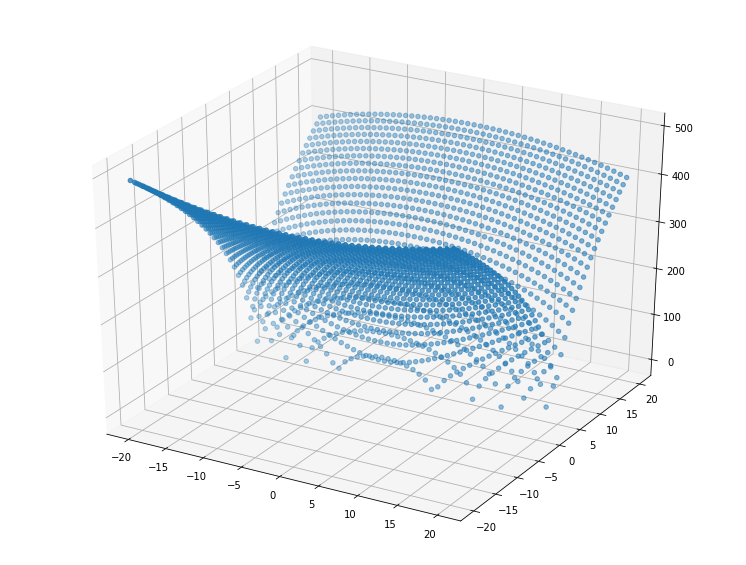

In [14]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, twoD_function_y);

In [1086]:
%autoreload 2

In [1089]:
bo_implementation = IBO()

In [1090]:
test_x = np.array(np.linspace(-10,10,1000)).reshape(-1,1)
train_x = np.array(np.random.choice(test_x.ravel())).reshape(-1,1)
train_y_numbers = np.array([oneD_function(_) for _ in train_x]).reshape(-1,1)

# One Dimensional

In [1091]:
bo_implementation.fit(train_x,train_y_numbers, test_x, oneD_function, y_func_type='real' ,samples = 10)

In [942]:
# one sample
x_sampled_points, y_sampled_points, best_x, best_y = bo_implementation.predict()

Bayesian Optimization just sampled point = [ 26.32632633]
Best x (Bayesian Optimization) = [ 26.32632633],                          Best y = [ 4.70883555]
[0.050050050050050053] x sampeld points first before


In [1092]:
# find the max
bo_implementation.maximize(n_steps=10)

853 max_improv_x_idx
Bayesian Optimization just sampled point = [ 7.07707708]
Best x (Bayesian Optimization) = [ 7.07707708],                          Best y = [ 201.86406133]
[-7.4574574574574575] x sampeld points first before
[-7.4574574574574575, array([ 7.07707708])] x sampeld points first before
2 len train points x after
[[-9.93993994]
 [ 7.07707708]] train points x after
201.849543522 0.536189092332 max min mus
[[-10.        ]
 [ -9.97997998]
 [ -9.95995996]
 [ -9.93993994]
 [ -9.91991992]
 [ -9.8998999 ]
 [ -9.87987988]
 [ -9.85985986]
 [ -9.83983984]
 [ -9.81981982]
 [ -9.7997998 ]
 [ -9.77977978]
 [ -9.75975976]
 [ -9.73973974]
 [ -9.71971972]
 [ -9.6996997 ]
 [ -9.67967968]
 [ -9.65965966]
 [ -9.63963964]
 [ -9.61961962]
 [ -9.5995996 ]
 [ -9.57957958]
 [ -9.55955956]
 [ -9.53953954]
 [ -9.51951952]
 [ -9.4994995 ]
 [ -9.47947948]
 [ -9.45945946]
 [ -9.43943944]
 [ -9.41941942]
 [ -9.3993994 ]
 [ -9.37937938]
 [ -9.35935936]
 [ -9.33933934]
 [ -9.31931932]
 [ -9.2992993 ]
 [

[array([ -1.38169524e-09]), array([ -1.39795983e-09]), array([ -1.40637162e-09]), array([ -1.40018151e-09]), array([ -1.37480647e-09]), array([ -1.33793298e-09]), array([ -1.29173687e-09]), array([ -1.23708830e-09]), array([ -1.17688300e-09]), array([ -1.11233343e-09]), array([ -1.04213552e-09]), array([ -9.67840655e-10]), array([ -8.94302731e-10]), array([ -8.19060415e-10]), array([ -7.45414501e-10]), array([ -6.72402928e-10]), array([ -6.02491056e-10]), array([ -5.35693860e-10]), array([ -4.73154463e-10]), array([ -4.15344431e-10]), array([ -3.60713031e-10]), array([ -3.11857428e-10]), array([ -2.67069779e-10]), array([ -2.27518632e-10]), array([ -1.92051202e-10]), array([ -1.61213908e-10]), array([ -1.33997594e-10]), array([ -1.11014689e-10]), array([ -9.10386710e-11]), array([ -7.42229585e-11]), array([ -5.99894270e-11]), array([ -4.82311115e-11]), array([ -3.84911852e-11]), array([ -3.05166369e-11]), array([ -2.39767179e-11]), array([ -1.87355996e-11]), array([ -1.45472946e-11]), 

205.01441981 -3.20599265114 max min mus
[[-10.        ]
 [ -9.97997998]
 [ -9.95995996]
 [ -9.93993994]
 [ -9.91991992]
 [ -9.8998999 ]
 [ -9.87987988]
 [ -9.85985986]
 [ -9.83983984]
 [ -9.81981982]
 [ -9.7997998 ]
 [ -9.77977978]
 [ -9.75975976]
 [ -9.73973974]
 [ -9.71971972]
 [ -9.6996997 ]
 [ -9.67967968]
 [ -9.65965966]
 [ -9.63963964]
 [ -9.61961962]
 [ -9.5995996 ]
 [ -9.57957958]
 [ -9.55955956]
 [ -9.53953954]
 [ -9.51951952]
 [ -9.4994995 ]
 [ -9.47947948]
 [ -9.45945946]
 [ -9.43943944]
 [ -9.41941942]
 [ -9.3993994 ]
 [ -9.37937938]
 [ -9.35935936]
 [ -9.33933934]
 [ -9.31931932]
 [ -9.2992993 ]
 [ -9.27927928]
 [ -9.25925926]
 [ -9.23923924]
 [ -9.21921922]
 [ -9.1991992 ]
 [ -9.17917918]
 [ -9.15915916]
 [ -9.13913914]
 [ -9.11911912]
 [ -9.0990991 ]
 [ -9.07907908]
 [ -9.05905906]
 [ -9.03903904]
 [ -9.01901902]
 [ -8.998999  ]
 [ -8.97897898]
 [ -8.95895896]
 [ -8.93893894]
 [ -8.91891892]
 [ -8.8988989 ]
 [ -8.87887888]
 [ -8.85885886]
 [ -8.83883884]
 [ -8.81881882]


223.028077838 -3.28972588234 max min mus
[[-10.        ]
 [ -9.97997998]
 [ -9.95995996]
 [ -9.93993994]
 [ -9.91991992]
 [ -9.8998999 ]
 [ -9.87987988]
 [ -9.85985986]
 [ -9.83983984]
 [ -9.81981982]
 [ -9.7997998 ]
 [ -9.77977978]
 [ -9.75975976]
 [ -9.73973974]
 [ -9.71971972]
 [ -9.6996997 ]
 [ -9.67967968]
 [ -9.65965966]
 [ -9.63963964]
 [ -9.61961962]
 [ -9.5995996 ]
 [ -9.57957958]
 [ -9.55955956]
 [ -9.53953954]
 [ -9.51951952]
 [ -9.4994995 ]
 [ -9.47947948]
 [ -9.45945946]
 [ -9.43943944]
 [ -9.41941942]
 [ -9.3993994 ]
 [ -9.37937938]
 [ -9.35935936]
 [ -9.33933934]
 [ -9.31931932]
 [ -9.2992993 ]
 [ -9.27927928]
 [ -9.25925926]
 [ -9.23923924]
 [ -9.21921922]
 [ -9.1991992 ]
 [ -9.17917918]
 [ -9.15915916]
 [ -9.13913914]
 [ -9.11911912]
 [ -9.0990991 ]
 [ -9.07907908]
 [ -9.05905906]
 [ -9.03903904]
 [ -9.01901902]
 [ -8.998999  ]
 [ -8.97897898]
 [ -8.95895896]
 [ -8.93893894]
 [ -8.91891892]
 [ -8.8988989 ]
 [ -8.87887888]
 [ -8.85885886]
 [ -8.83883884]
 [ -8.81881882]

[array([ -1.45775268e-07]), array([ -1.48320194e-07]), array([ -1.50116687e-07]), array([ -1.50909081e-07]), array([ -1.50125429e-07]), array([ -1.48273649e-07]), array([ -1.45621631e-07]), array([ -1.42474850e-07]), array([ -1.38554896e-07]), array([ -1.34083191e-07]), array([ -1.29050964e-07]), array([ -1.23546476e-07]), array([ -1.17609493e-07]), array([ -1.11614371e-07]), array([ -1.05136472e-07]), array([ -9.86941163e-08]), array([ -9.20369911e-08]), array([ -8.54812995e-08]), array([ -7.89919896e-08]), array([ -7.25188635e-08]), array([ -6.63738573e-08]), array([ -6.04026052e-08]), array([ -5.46841233e-08]), array([ -4.93029320e-08]), array([ -4.41780487e-08]), array([ -3.93768059e-08]), array([ -3.49612356e-08]), array([ -3.08918085e-08]), array([ -2.71501396e-08]), array([ -2.37420415e-08]), array([ -2.06845760e-08]), array([ -1.79051444e-08]), array([ -1.54576684e-08]), array([ -1.32545224e-08]), array([ -1.13317252e-08]), array([ -9.63974959e-09]), array([ -8.14918061e-09]), 

256.419875347 -1.34673063871 max min mus
[[-10.        ]
 [ -9.97997998]
 [ -9.95995996]
 [ -9.93993994]
 [ -9.91991992]
 [ -9.8998999 ]
 [ -9.87987988]
 [ -9.85985986]
 [ -9.83983984]
 [ -9.81981982]
 [ -9.7997998 ]
 [ -9.77977978]
 [ -9.75975976]
 [ -9.73973974]
 [ -9.71971972]
 [ -9.6996997 ]
 [ -9.67967968]
 [ -9.65965966]
 [ -9.63963964]
 [ -9.61961962]
 [ -9.5995996 ]
 [ -9.57957958]
 [ -9.55955956]
 [ -9.53953954]
 [ -9.51951952]
 [ -9.4994995 ]
 [ -9.47947948]
 [ -9.45945946]
 [ -9.43943944]
 [ -9.41941942]
 [ -9.3993994 ]
 [ -9.37937938]
 [ -9.35935936]
 [ -9.33933934]
 [ -9.31931932]
 [ -9.2992993 ]
 [ -9.27927928]
 [ -9.25925926]
 [ -9.23923924]
 [ -9.21921922]
 [ -9.1991992 ]
 [ -9.17917918]
 [ -9.15915916]
 [ -9.13913914]
 [ -9.11911912]
 [ -9.0990991 ]
 [ -9.07907908]
 [ -9.05905906]
 [ -9.03903904]
 [ -9.01901902]
 [ -8.998999  ]
 [ -8.97897898]
 [ -8.95895896]
 [ -8.93893894]
 [ -8.91891892]
 [ -8.8988989 ]
 [ -8.87887888]
 [ -8.85885886]
 [ -8.83883884]
 [ -8.81881882]

[array([ -1.34430137e-07]), array([ -1.36109718e-07]), array([ -1.37070775e-07]), array([ -1.37349571e-07]), array([ -1.36417842e-07]), array([ -1.34889330e-07]), array([ -1.32626631e-07]), array([ -1.29788592e-07]), array([ -1.26468807e-07]), array([ -1.22625584e-07]), array([ -1.18317496e-07]), array([ -1.13711252e-07]), array([ -1.08733370e-07]), array([ -1.03528357e-07]), array([ -9.81099371e-08]), array([ -9.25910186e-08]), array([ -8.69463020e-08]), array([ -8.12110991e-08]), array([ -7.55832815e-08]), array([ -7.00623637e-08]), array([ -6.45582708e-08]), array([ -5.93209493e-08]), array([ -5.42060120e-08]), array([ -4.93478339e-08]), array([ -4.47098846e-08]), array([ -4.03444672e-08]), array([ -3.62258674e-08]), array([ -3.24168583e-08]), array([ -2.88645484e-08]), array([ -2.55821225e-08]), array([ -2.25905224e-08]), array([ -1.98775975e-08]), array([ -1.74144293e-08]), array([ -1.51761135e-08]), array([ -1.31856756e-08]), array([ -1.14048343e-08]), array([ -9.82653945e-09]), 

283.348400321 -0.469160210809 max min mus
[[-10.        ]
 [ -9.97997998]
 [ -9.95995996]
 [ -9.93993994]
 [ -9.91991992]
 [ -9.8998999 ]
 [ -9.87987988]
 [ -9.85985986]
 [ -9.83983984]
 [ -9.81981982]
 [ -9.7997998 ]
 [ -9.77977978]
 [ -9.75975976]
 [ -9.73973974]
 [ -9.71971972]
 [ -9.6996997 ]
 [ -9.67967968]
 [ -9.65965966]
 [ -9.63963964]
 [ -9.61961962]
 [ -9.5995996 ]
 [ -9.57957958]
 [ -9.55955956]
 [ -9.53953954]
 [ -9.51951952]
 [ -9.4994995 ]
 [ -9.47947948]
 [ -9.45945946]
 [ -9.43943944]
 [ -9.41941942]
 [ -9.3993994 ]
 [ -9.37937938]
 [ -9.35935936]
 [ -9.33933934]
 [ -9.31931932]
 [ -9.2992993 ]
 [ -9.27927928]
 [ -9.25925926]
 [ -9.23923924]
 [ -9.21921922]
 [ -9.1991992 ]
 [ -9.17917918]
 [ -9.15915916]
 [ -9.13913914]
 [ -9.11911912]
 [ -9.0990991 ]
 [ -9.07907908]
 [ -9.05905906]
 [ -9.03903904]
 [ -9.01901902]
 [ -8.998999  ]
 [ -8.97897898]
 [ -8.95895896]
 [ -8.93893894]
 [ -8.91891892]
 [ -8.8988989 ]
 [ -8.87887888]
 [ -8.85885886]
 [ -8.83883884]
 [ -8.81881882

[array([ -4.98072272e-15]), array([ -5.07057680e-15]), array([ -5.12854010e-15]), array([ -5.13750069e-15]), array([ -5.07556851e-15]), array([ -4.98486315e-15]), array([ -4.85784755e-15]), array([ -4.69872950e-15]), array([ -4.50840175e-15]), array([ -4.30638291e-15]), array([ -4.07944109e-15]), array([ -3.83322215e-15]), array([ -3.57662396e-15]), array([ -3.31809525e-15]), array([ -3.05221014e-15]), array([ -2.79497438e-15]), array([ -2.53540543e-15]), array([ -2.28989517e-15]), array([ -2.04972721e-15]), array([ -1.82216350e-15]), array([ -1.61313557e-15]), array([ -1.41434478e-15]), array([ -1.23152547e-15]), array([ -1.06750600e-15]), array([ -9.18217269e-16]), array([ -7.84523880e-16]), array([ -6.66433516e-16]), array([ -5.61772055e-16]), array([ -4.70829039e-16]), array([ -3.92304560e-16]), array([ -3.24660802e-16]), array([ -2.67021339e-16]), array([ -2.18130280e-16]), array([ -1.77557390e-16]), array([ -1.43115854e-16]), array([ -1.15037768e-16]), array([ -9.18068556e-17]), 

307.645455652 0.229454091087 max min mus
[[-10.        ]
 [ -9.97997998]
 [ -9.95995996]
 [ -9.93993994]
 [ -9.91991992]
 [ -9.8998999 ]
 [ -9.87987988]
 [ -9.85985986]
 [ -9.83983984]
 [ -9.81981982]
 [ -9.7997998 ]
 [ -9.77977978]
 [ -9.75975976]
 [ -9.73973974]
 [ -9.71971972]
 [ -9.6996997 ]
 [ -9.67967968]
 [ -9.65965966]
 [ -9.63963964]
 [ -9.61961962]
 [ -9.5995996 ]
 [ -9.57957958]
 [ -9.55955956]
 [ -9.53953954]
 [ -9.51951952]
 [ -9.4994995 ]
 [ -9.47947948]
 [ -9.45945946]
 [ -9.43943944]
 [ -9.41941942]
 [ -9.3993994 ]
 [ -9.37937938]
 [ -9.35935936]
 [ -9.33933934]
 [ -9.31931932]
 [ -9.2992993 ]
 [ -9.27927928]
 [ -9.25925926]
 [ -9.23923924]
 [ -9.21921922]
 [ -9.1991992 ]
 [ -9.17917918]
 [ -9.15915916]
 [ -9.13913914]
 [ -9.11911912]
 [ -9.0990991 ]
 [ -9.07907908]
 [ -9.05905906]
 [ -9.03903904]
 [ -9.01901902]
 [ -8.998999  ]
 [ -8.97897898]
 [ -8.95895896]
 [ -8.93893894]
 [ -8.91891892]
 [ -8.8988989 ]
 [ -8.87887888]
 [ -8.85885886]
 [ -8.83883884]
 [ -8.81881882]

[array([ -1.09101344e-14]), array([ -1.11196552e-14]), array([ -1.12543373e-14]), array([ -1.13061791e-14]), array([ -1.12695295e-14]), array([ -1.11485228e-14]), array([ -1.09392556e-14]), array([ -1.06696632e-14]), array([ -1.03490394e-14]), array([ -9.97578054e-15]), array([ -9.56607685e-15]), array([ -9.10521118e-15]), array([ -8.62640968e-15]), array([ -8.11618496e-15]), array([ -7.59839661e-15]), array([ -7.06961645e-15]), array([ -6.53376159e-15]), array([ -6.00303650e-15]), array([ -5.48122761e-15]), array([ -4.98652396e-15]), array([ -4.50213192e-15]), array([ -4.04292562e-15]), array([ -3.61303177e-15]), array([ -3.20710324e-15]), array([ -2.83064412e-15]), array([ -2.48666900e-15]), array([ -2.17141977e-15]), array([ -1.88689762e-15]), array([ -1.62955253e-15]), array([ -1.39850399e-15]), array([ -1.19524991e-15]), array([ -1.01669171e-15]), array([ -8.58993975e-16]), array([ -7.22779184e-16]), array([ -6.05291195e-16]), array([ -5.03729009e-16]), array([ -4.17311779e-16]), 

313.784933027 -2.21925692044 max min mus
[[-10.        ]
 [ -9.97997998]
 [ -9.95995996]
 [ -9.93993994]
 [ -9.91991992]
 [ -9.8998999 ]
 [ -9.87987988]
 [ -9.85985986]
 [ -9.83983984]
 [ -9.81981982]
 [ -9.7997998 ]
 [ -9.77977978]
 [ -9.75975976]
 [ -9.73973974]
 [ -9.71971972]
 [ -9.6996997 ]
 [ -9.67967968]
 [ -9.65965966]
 [ -9.63963964]
 [ -9.61961962]
 [ -9.5995996 ]
 [ -9.57957958]
 [ -9.55955956]
 [ -9.53953954]
 [ -9.51951952]
 [ -9.4994995 ]
 [ -9.47947948]
 [ -9.45945946]
 [ -9.43943944]
 [ -9.41941942]
 [ -9.3993994 ]
 [ -9.37937938]
 [ -9.35935936]
 [ -9.33933934]
 [ -9.31931932]
 [ -9.2992993 ]
 [ -9.27927928]
 [ -9.25925926]
 [ -9.23923924]
 [ -9.21921922]
 [ -9.1991992 ]
 [ -9.17917918]
 [ -9.15915916]
 [ -9.13913914]
 [ -9.11911912]
 [ -9.0990991 ]
 [ -9.07907908]
 [ -9.05905906]
 [ -9.03903904]
 [ -9.01901902]
 [ -8.998999  ]
 [ -8.97897898]
 [ -8.95895896]
 [ -8.93893894]
 [ -8.91891892]
 [ -8.8988989 ]
 [ -8.87887888]
 [ -8.85885886]
 [ -8.83883884]
 [ -8.81881882]

[array([ -4.41357461e-24]), array([ -4.55861879e-24]), array([ -4.65316093e-24]), array([ -4.70713683e-24]), array([ -4.68965835e-24]), array([ -4.62237241e-24]), array([ -4.50646039e-24]), array([ -4.36895799e-24]), array([ -4.18102932e-24]), array([ -3.97137121e-24]), array([ -3.73897194e-24]), array([ -3.49285591e-24]), array([ -3.22657494e-24]), array([ -2.95417588e-24]), array([ -2.67968508e-24]), array([ -2.41064784e-24]), array([ -2.14763427e-24]), array([ -1.90000227e-24]), array([ -1.66103846e-24]), array([ -1.44307375e-24]), array([ -1.23984368e-24]), array([ -1.05746706e-24]), array([ -8.94365999e-25]), array([ -7.49619115e-25]), array([ -6.22577736e-25]), array([ -5.12170702e-25]), array([ -4.18326182e-25]), array([ -3.38809659e-25]), array([ -2.71983134e-25]), array([ -2.16564428e-25]), array([ -1.70900049e-25]), array([ -1.34156778e-25]), array([ -1.04086427e-25]), array([ -8.03772009e-26]), array([ -6.14198828e-26]), array([ -4.66499707e-26]), array([ -3.51210445e-26]), 

KeyboardInterrupt: 

# Two dimensional real function

In [92]:
%autoreload 2

In [93]:
bo_implementation_2d = IBO()

In [94]:
bo_implementation_2d .fit(train_x_2d, train_y_2d,combo_domain, twoD_function, y_func_type='real' ,samples = 10)

In [91]:
x_sampled_points, y_sampled_points, best_x, best_y = bo_implementation_2d.predict()

Bayesian Optimization just sampled point = [ 11.83673469 -18.36734694]
Best x (Bayesian Optimization) = [ 11.83673469 -18.36734694], Best y = 444.83539154763173


In [96]:
 bo_implementation_2d.maximize(n_steps=10)

Bayesian Optimization just sampled point = [[-19.18367347 -11.02040816]]
Best x (Bayesian Optimization) = [[-19.18367347 -11.02040816]],                         Best y = 383.5046878634245
Bayesian Optimization just sampled point = [-16.73469388  -4.48979592]
Best x (Bayesian Optimization) = [[-19.18367347 -11.02040816]], Best y = 383.5046878634245
Bayesian Optimization just sampled point = [-15.91836735 -12.65306122]
Best x (Bayesian Optimization) = [-15.91836735 -12.65306122], Best y = 389.764269788735
Bayesian Optimization just sampled point = [-15.91836735 -12.65306122]
Best x (Bayesian Optimization) = [-15.91836735 -12.65306122], Best y = 389.764269788735
Bayesian Optimization just sampled point = [ 12.65306122  15.10204082]
Best x (Bayesian Optimization) = [-15.91836735 -12.65306122], Best y = 389.764269788735
Bayesian Optimization just sampled point = [-15.91836735 -12.65306122]
Best x (Bayesian Optimization) = [-15.91836735 -12.65306122], Best y = 389.764269788735
Bayesian Optim

(array([-15.91836735, -12.65306122]), 389.76426978873502)

In [52]:
twoD_domain = np.linspace(-20,20)
combo_domain = np.squeeze(np.array([list(itertools.product(*[twoD_domain,twoD_domain]))]))
xs = [combo_domain[i][0] for i in range(len(combo_domain))]
ys = [combo_domain[i][1] for i in range(len(combo_domain))]

In [53]:
twoD_function_y = [twoD_function(combo_domain[i][0],combo_domain[i][1]) for i in range(len(combo_domain))]

In [83]:
train_x_2d = np.array([[10,4]])

In [84]:
train_y_2d = np.array([[twoD_function(train_x_2d[0][0],train_x_2d[0][1])]])

In [85]:
train_y_2d

array([[ 173.40508076]])